# SI: Caffeine Solvation in Electrolyte Solutions
Stefan Hervø-Hansen<sup>a,b</sup>, Nobuyuki Matubayasi<sup>b,*</sup>, Mikael Lund<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Therotical Chemistry, Department of Chemistry, Lund University, Lund SE 221 00, Sweden.<br> <sup>b</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>*</sup> To whom correspondence may be addressed nobuyuki@cheng.es.osaka-u.ac.jp and mikael.lund@teokem.lu.se.

## Introduction

We present a study of the solvation free energy of caffeine in electrolyte solutions using the energy representation description in combination with all-atom simulations. In specific we desire to calculate Setschenow (Sechenov) coefficients,$k_s$,[<sup>1</sup>](#fn1) for various salts. The Setschenow equation[<sup>1</sup>](#fn1) is on the $\ln$-scale given as
$$ \ln S/S_0 =  -k_sc_s = \ln\gamma = \Delta\mu^{ex} \tag 1$$
where $S$ and $S_0$ are solubilities in pure water and an electrolyte solution of concentration $c_s$. In litterature eq. 1 is most commonly presented on $\log_{10}$ scale, however on the persented form, the Setschenow equation shows its clear relationship to the activity coefficient and chemical potential. Finally we also desire to conduct a surface decomposition of caffeine to investigate the solvation free energy contribution for the different salts to the motifs of caffeine.

## Methods & Materials
Molecular dynamics simulations was conducted using the openMM (7.4.0)[<sup>2</sup>](#fn2) software package modded with the openmmtools[<sup>3</sup>](#fn3) and parmed[<sup>4</sup>](#fn4) packages. For the simulation of caffeine a GROMOS (ffGF53a6) derived Kirkwood-Buff force field with adjustments to the partial charges and geometrical parameters, which has previously been able able to reproduce experimental solubilities of caffeine in water and urea solutions[<sup>5</sup>](#fn5) was employed with the SPC/E[<sup>6</sup>](#fn6) force field employed for water and optimized ion parameters for alkali cations and halide anions[<sup>7</sup>](#fn7). The isothermal-isobaric ensemble was sampled using a combination of a geodesic Langevin integrator[<sup>8</sup>](#fn8) and a Monte Carlo barostat[<sup>9,</sup>](#fn9)[<sup>10</sup>](#fn10). The trajectories were analysed using MDtraj[<sup>11</sup>](#fn11) for structual properties, while ERmod[<sup>12</sup>](#fn12) was utilized for the calculation of solvation free energies.


## References
1. <span id="fn1"> Setschenow J (1889) Über die Konstitution der Salzlösungen auf Grund ihres Verhaltens zu Kohlensäure. Zeitschrift für Physikalische Chemie 4U(1):117–125.
2. <span id="fn1"> Eastman P, et al. (2017) OpenMM 7: Rapid development of high performance algorithms for molecular dynamics. PLOS Computational Biology 13(7):e1005659.</span><br>
3. <span id="fn2"> https://github.com/choderalab/openmmtools</span><br>
4. <span id="fn3"> https://github.com/ParmEd/ParmEd </span><br>
5. <span id="fn4"> Sanjeewa R, Weerasinghe S (2010) Development of a molecular mechanics force field for caffeine to investigate the interactions of caffeine in different solvent media. Journal of Molecular Structure: THEOCHEM 944(1–3):116–123. </span><br>
6. <span id="fn5"> Berendsen HJC, Grigera JR, Straatsma TP (1987) The missing term in effective pair potentials. The Journal of Physical Chemistry 91(24):6269–6271. </span><br>
7. <span id="fn6"> Heyda J, Vincent JC, Tobias DJ, Dzubiella J, Jungwirth P (2010) Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations ofN-Methylacetamide in Aqueous Salt Solutions. The Journal of Physical Chemistry B 114(2):1213–1220. </span><br>
8. <span id="fn8"> Leimkuhler B, Matthews C (2016) Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 472(2189):20160138. </span><br>
9. <span id="fn9"> Chow K-H, Ferguson DM (1995) Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91(1–3):283–289. </span><br>
10. <span id="fn10"> Åqvist J, Wennerström P, Nervall M, Bjelic S, Brandsdal BO (2004) Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384(4–6):288–294. </span><br>
11. <span id="fn11"> McGibbon RT, et al. (2015) MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109(8):1528–1532. </span><br>
12. <span id="fn12"> Sakuraba S, Matubayasi N (2014) Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. Journal of Computational Chemistry 35(21):1592–1608. </span><br>

### Import of python models

In [21]:
# Notebook dependent libs
import parmed as pmd
import math
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from uncertainties import unumpy
import os, time, re, yaml

# Simulation specific libs
import sys
from simtk.openmm import app
import simtk.openmm as mm
import openmmtools as mmtools
import parmed as pmd
from mdtraj.reporters import XTCReporter

homedir='/home/stefan/Caffeine_solubility'

### Simulation settings

In [20]:
# State of simulations, (outFreq is steps per frame)
states = {
          'sol': {'Nsteps': 25000000,  'OutFreq': 50}, # 50 nanoseconds, 500.000 frames
          'ref': {'Nsteps': 5000000,  'OutFreq': 500} # 10 nanoseconds, 10.000 framess
         }

salts = {'NaCl': {'Cation': 'Na', 'Anion': 'Cl'},
         'NaI' : {'Cation': 'Na', 'Anion': 'I' }
        }

# Concentrations of salts behaiving ideally
salt_concentrations = {0.00: {'Caffeine': 1, 'Water': 1000, 'Cation':0,  'Anion':0},
#                       0.25: {'Caffeine': 1, 'Water': 1000, 'Cation':5,  'Anion':5},    # Calc concentration
                       0.50: {'Caffeine': 1, 'Water': 1000, 'Cation':9,  'Anion':9},
#                       0.75: {'Caffeine': 1, 'Water': 1000, 'Cation':14, 'Anion':14},   # Calc concentration
                       1.00: {'Caffeine': 1, 'Water': 1000, 'Cation':18, 'Anion':18},
#                       1.25: {'Caffeine': 1, 'Water': 1000, 'Cation':23, 'Anion':23},   # Calc concentration   
                       1.50: {'Caffeine': 1, 'Water': 1000, 'Cation':27, 'Anion':27},   
#                       1.75: {'Caffeine': 1, 'Water': 1000, 'Cation':32, 'Anion':32},   # Calc concentration
#                       2.00: {'Caffeine': 1, 'Water': 1000, 'Cation':36, 'Anion':36}   
                      }

### Construction of topology (.top) and structure (.pdb) files

In [5]:
%cd -q $homedir
for concentration, Nparticles in salt_concentrations.items():
    conc = '{0:.2f}'.format(concentration)
    %cd -q $homedir/Simulations/NaCl/$conc
    
    # Packmol Input
    packmol_script="""
tolerance 2.0
filetype pdb
output Caffeine_NaCl_sol.pdb
add_box_sides 0.5

structure ../../../PDB_files/single-caffeine-molecule.pdb
        number {N_caffeine}
        fixed 16. 16. 16. 0. 0. 0.
        centerofmass
end structure

structure ../../../PDB_files/water.pdb
        number {N_wat}
        inside cube 0. 0. 0. 32.
end structure

{salt}structure ../../../PDB_files/Na.pdb
{salt}        number {N_Na}
{salt}        inside cube 0. 0. 0. 32.
{salt}end structure

{salt}structure ../../../PDB_files/Cl.pdb
{salt}        number {N_Cl}
{salt}        inside cube 0. 0. 0. 32.
{salt}end structure
"""
    with open('packmol.in', 'w') as text_file:
        # fix for no salt:
        if concentration:
            salt=''
        else:
            salt='#'
        text_file.write(packmol_script.format(N_caffeine=Nparticles['Caffeine'], N_wat=Nparticles['Water'],
                                              N_Na=Nparticles['Cation'], N_Cl=Nparticles['Anion'], salt=salt))
    !packmol < packmol.in

    # Topology input
    topology="""
[ system ]
; Name
Caffeine in NaCl {conc} M aqueous solution.

[ defaults ]
; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ
1               3               yes             0.5     0.8333

; Include all atomtypes
#include "/home/stefan/Caffeine_solubility/force_fields/atomtypes_spc.itp"
#include "/home/stefan/Caffeine_solubility/force_fields/atomtypes_ions.itp"
#include "/home/stefan/Caffeine_solubility/force_fields/atomtypes_caffeine.itp"

; Include all topologies
#include "/home/stefan/Caffeine_solubility/force_fields/ions.itp"
#include "/home/stefan/Caffeine_solubility/force_fields/spce.itp"
#include "/home/stefan/Caffeine_solubility/force_fields/caffeine-KBFF.itp"

[ molecules ]
; Compound         #mols
2S09               {N_caffeine}
SOL                {N_wat}
{salt}Cl                 {N_Cl}
{salt}Na                 {N_Na}
"""
    with open('Caffeine_NaCl_sol.top', 'w') as text_file:
        # fix for no salt:
        if concentration:
            salt=''
        else:
            salt=';'
        text_file.write(topology.format(conc=concentration, salt=salt,
                                        N_caffeine=Nparticles['Caffeine'], N_wat=Nparticles['Water'],
                                        N_Na=Nparticles['Cation'], N_Cl=Nparticles['Anion']))
    
    # Solvated state
    mol = pmd.load_file('Caffeine_NaCl_sol.top', xyz='Caffeine_NaCl_sol.pdb')
    mol.save('Caffeine_NaCl_sol.top', overwrite=True)
    
    # Reference state
    mol = pmd.load_file('Caffeine_NaCl_sol.top', xyz='Caffeine_NaCl_sol.pdb')
    mol.strip(':2S09')
    mol.save('Caffeine_NaCl_ref.top')
    mol.save('Caffeine_NaCl_ref.pdb')
    
    print('Wrote initial configurations and topology files to'+os.getcwd())


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                           Included as part of Packmol Memgen
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will print BOX SIDE informations. 
  Will sum   0.50000000000000000       to each side length on print
  Seed for random number generator:      1234567
  Output file: Caffeine_NaI_sol.pdb
  Reading coordinate file: ../../../PDB_files/single-caffeine-molecule.pdb
  Reading coordinate file: ../../../PDB_files/water.pdb
  Number of independent structures:            2
  The structures are: 
  Structure           

/home/stefan/miniconda3/lib/python3.7/site-packages/parmed/gromacs/gromacstop.py:1025: GromacsWarning: 28 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!
  GromacsWarning)


Wrote initial configurations and topology files to/home/stefan/Caffeine_solubility/Simulations/NaI/0.00

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                           Included as part of Packmol Memgen
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will print BOX SIDE informations. 
  Will sum   0.50000000000000000       to each side length on print
  Seed for random number generator:      1234567
  Output file: Caffeine_NaI_sol.pdb
  Reading coordinate file: ../../../PDB_files/single-caffeine-molecule.pdb
  Reading coordinate file: ../../../PDB_files/

          |********************************************************

  Function value from last GENCAN loop: f = .14588E-01
  Best function value before: f = .22197E+03
  Improvement from best function value:    99.99 %
  Improvement from last loop:    99.99 %
  Maximum violation of target distance:     0.000000
  Maximum violation of the constraints: .53262E-02

################################################################################

                                 Success! 
              Final objective function value: .14588E-01
              Maximum violation of target distance:   0.000000
              Maximum violation of the constraints: .53262E-02

--------------------------------------------------------------------------------

              Please cite this work if Packmol was useful: 

           L. Martinez, R. Andrade, E. G. Birgin, J. M. Martinez, 
         PACKMOL: A package for building initial configurations for
                   molecular dynamics simulatio

/home/stefan/miniconda3/lib/python3.7/site-packages/parmed/gromacs/gromacstop.py:1025: GromacsWarning: 28 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!
  GromacsWarning)


Wrote initial configurations and topology files to/home/stefan/Caffeine_solubility/Simulations/NaI/0.50

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                           Included as part of Packmol Memgen
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will print BOX SIDE informations. 
  Will sum   0.50000000000000000       to each side length on print
  Seed for random number generator:      1234567
  Output file: Caffeine_NaI_sol.pdb
  Reading coordinate file: ../../../PDB_files/single-caffeine-molecule.pdb
  Reading coordinate file: ../../../PDB_files/

          |******************************************************************|


  Function value from last GENCAN loop: f = .10342E-01
  Best function value before: f = .33556E+03
  Improvement from best function value:    99.99 %
  Improvement from last loop:    99.99 %
  Maximum violation of target distance:     0.000000
  Maximum violation of the constraints: .36107E-02

################################################################################

                                 Success! 
              Final objective function value: .10342E-01
              Maximum violation of target distance:   0.000000
              Maximum violation of the constraints: .36107E-02

--------------------------------------------------------------------------------

              Please cite this work if Packmol was useful: 

           L. Martinez, R. Andrade, E. G. Birgin, J. M. Martinez, 
         PACKMOL: A package for building initial configurations for
                   molecular dynami

/home/stefan/miniconda3/lib/python3.7/site-packages/parmed/gromacs/gromacstop.py:1025: GromacsWarning: 28 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!
  GromacsWarning)


Wrote initial configurations and topology files to/home/stefan/Caffeine_solubility/Simulations/NaI/1.00

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                           Included as part of Packmol Memgen
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will print BOX SIDE informations. 
  Will sum   0.50000000000000000       to each side length on print
  Seed for random number generator:      1234567
  Output file: Caffeine_NaI_sol.pdb
  Reading coordinate file: ../../../PDB_files/single-caffeine-molecule.pdb
  Reading coordinate file: ../../../PDB_files/

          |******************************************************************|
          |*********************

  Function value from last GENCAN loop: f = .10263E-01
  Best function value before: f = .67406E+03
  Improvement from best function value:    99.99 %
  Improvement from last loop:    99.99 %
  Maximum violation of target distance:     0.000000
  Maximum violation of the constraints: .33526E-02

################################################################################

                                 Success! 
              Final objective function value: .10263E-01
              Maximum violation of target distance:   0.000000
              Maximum violation of the constraints: .33526E-02

--------------------------------------------------------------------------------

              Please cite this work if Packmol was useful: 

           L. Martinez, R. Andrade, E. G. Birgin, J. M. Martinez, 
         PACKMOL: A package for building initial configurations for
   

/home/stefan/miniconda3/lib/python3.7/site-packages/parmed/gromacs/gromacstop.py:1025: GromacsWarning: 28 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!
  GromacsWarning)


Wrote initial configurations and topology files to/home/stefan/Caffeine_solubility/Simulations/NaI/1.50

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                           Included as part of Packmol Memgen
                                                              Version 18.169 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will print BOX SIDE informations. 
  Will sum   0.50000000000000000       to each side length on print
  Seed for random number generator:      1234567
  Output file: Caffeine_NaI_sol.pdb
  Reading coordinate file: ../../../PDB_files/single-caffeine-molecule.pdb
  Reading coordinate file: ../../../PDB_files/

  Current point written to file: Caffeine_NaI_sol.pdb
--------------------------------------------------------------------------------
  Packing solved for molecules of type           4
  Objective function value:    0.0000000000000000     
  Maximum violation of target distance:    0.0000000000000000     
  Max. constraint violation:    0.0000000000000000     
--------------------------------------------------------------------------------

################################################################################

  Packing all molecules together 

################################################################################


--------------------------------------------------------------------------------

  Starting GENCAN loop:            0
  Scaling radii by:    1.1000000000000001     

  Packing:|0                                                             100%|
          |******************************************************************|
          |******************

/home/stefan/miniconda3/lib/python3.7/site-packages/parmed/gromacs/gromacstop.py:1025: GromacsWarning: 28 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!
  GromacsWarning)


Wrote initial configurations and topology files to/home/stefan/Caffeine_solubility/Simulations/NaI/2.00


## Molecular dynamics simulations
### Simulation setup using OpenMM

In [6]:
%cd -q $homedir
N_simulations = 0

for concentration in salt_concentrations:
    conc = '{0:.2f}'.format(concentration)
    %cd -q $homedir/Simulations/NaCl/$conc
    for state, settings in states.items():
        
        openmm_script="""
# Imports
import sys
import os
from simtk.openmm import app
import simtk.openmm as mm
import openmmtools as mmtools
from parmed import load_file, unit as u
from mdtraj.reporters import XTCReporter

print('Loading initial configuration and toplogy')
init_conf = load_file('Caffeine_NaCl_{state}.top', xyz='Caffeine_NaCl_{state}.pdb')

# Creating system
print('Creating OpenMM System')
system = init_conf.createSystem(nonbondedMethod=app.PME, ewaldErrorTolerance=0.00001,
                                nonbondedCutoff=1.2*u.nanometers, constraints=app.HBonds)

# Calculating total mass of system
total_mass = 0
for i in range(system.getNumParticles()):
    total_mass += system.getParticleMass(i).value_in_unit(u.dalton)
total_mass *= u.dalton

# Temperature-coupling by geodesic Langevin integrator (NVT)
integrator = mmtools.integrators.GeodesicBAOABIntegrator(K_r = 3,
                                                         temperature = 298.15*u.kelvin,
                                                         collision_rate = 1.0/u.picoseconds,
                                                         timestep = 2.0*u.femtoseconds
                                                        )

# Pressure-coupling by a Monte Carlo Barostat (NPT)
system.addForce(mm.MonteCarloBarostat(1*u.bar, 298.15*u.kelvin, 25))

# Add LJ switching functions
forces = {{system.getForce(index).__class__.__name__: 
          system.getForce(index) for index in range(system.getNumForces())}}
forces['CustomNonbondedForce'].setUseSwitchingFunction(True)
forces['CustomNonbondedForce'].setSwitchingDistance(1*u.nanometer)

platform = mm.Platform.getPlatformByName('CUDA')
properties = {{'CudaPrecision': 'mixed', 'CudaDeviceIndex': '0'}}

# Create the Simulation object
sim = app.Simulation(init_conf.topology, system, integrator, platform, properties)

# Set the particle positions
sim.context.setPositions(init_conf.positions)

# Minimize the energy
print('Minimizing energy')
sim.minimizeEnergy(tolerance=1*u.kilojoule/u.mole, maxIterations=500000)
    
# Draw initial MB velocities
sim.context.setVelocitiesToTemperature(298.15*u.kelvin)

# Equlibrate simulation
print('Equilibrating...')
sim.step(500000)  # 500000*2 fs = 1.0 ns

# Print PME information
print('''
PARTICLE MESH EWALD PARAMETERS (Production run)
Separation parameter: {{}}
Number of grid points along the X axis: {{}}
Number of grid points along the Y axis: {{}}
Number of grid points along the Z axis: {{}}
'''.format(*forces['NonbondedForce'].getPMEParametersInContext(sim.context)))

# Set up the reporters
sim.reporters.append(app.StateDataReporter('output_{state}.dat', {outFreq}, totalSteps={Nsteps}+500000,
    time=True, potentialEnergy=True, kineticEnergy=True, temperature=True, volume=True, density=True,
    systemMass=total_mass, remainingTime=True, speed=True, separator='\t'))

# Set up trajectory reporter
sim.reporters.append(XTCReporter('trajectory_{state}.xtc', reportInterval={outFreq}, append=False))

# Run dynamics
print('Running dynamics! (NPT)')
sim.step({Nsteps})
"""
        with open('openMM_{state}.py'.format(state=state), 'w') as text_file:
            text_file.write(openmm_script.format(state=state, Nsteps=settings['Nsteps'], outFreq=settings['OutFreq']))
            N_simulations+=1
    print('Wrote run_openMM.py files to '+os.getcwd())

print('Simulations about to be submitted: {}'.format(N_simulations))

Wrote run_openMM.py files to /home/stefan/Caffeine_solubility/Simulations/NaI/0.00
Wrote run_openMM.py files to /home/stefan/Caffeine_solubility/Simulations/NaI/0.50
Wrote run_openMM.py files to /home/stefan/Caffeine_solubility/Simulations/NaI/1.00
Wrote run_openMM.py files to /home/stefan/Caffeine_solubility/Simulations/NaI/1.50
Wrote run_openMM.py files to /home/stefan/Caffeine_solubility/Simulations/NaI/2.00
Simulations about to be submitted: 10


### Submit script

In [7]:
for concentration in salt_concentrations:
    conc = '{0:.2f}'.format(concentration)
    %cd -q $homedir/Simulations/NaCl/$conc
    for state in states:
        
        submit_script="""#!/bin/bash
#PBS -l nodes=1:ppn=18:nu-G01:gpus=1  # 1 node, 18 cores, GPU node nu-G01, 1 gpu.
#PBS -N {conc}_M_NaCl_{state}         # Name of job
#PBS -e run_{state}.err               # error output
#PBS -o run_{state}.out               # output file name

source ~/.bashrc
source ~/.bash_profile
cd {path}

python openMM_{state}.py"""

        with open('submit_{state}.pbs'.format(state=state), 'w') as text_file:
            text_file.write(submit_script.format(conc=conc, state=state, path=os.getcwd()))
    !qsub submit_sol.pbs
    time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
    !qsub submit_ref.pbs
    time.sleep(1) # Safety in submission of jobs: can cause problems if too fast

9424.nu
9425.nu
9426.nu
9427.nu
9428.nu
9429.nu
9430.nu
9431.nu
9432.nu
9433.nu


### Prepare ERmod analysis
<img style="float: right;width:319.5px;height:312.5px;" src="images/ermod.png" title="Simulation flow" >

The determination of solvation free energies and chemical potentials though the ERmod software is conducted in two stages as illustrated in the figure. First is the determination of the energy distribution functions from the simulation trajectories obtained from molecular dynamics using the subprogram `ermod`. Second is the solvation free energy is determined from the energy distribution functions though an approximate functional using the subprogram `slvfe`.

Documentation for the parameter file `parameters_er` which determines how the `ermod` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-ermod03/). In the python code below it can be noted many of the parameters has been given the keyword `[correct]`, these settings are dependent on the simulation settings and or the software being used and are thus recommended not to be changed if using the openMM setup above. The parameters given the keyword `[to be set]` are settings either collected from the output of the openMM script or set by the user, in specific the values for `maxins` and `engdiv` should be given by the user are given the default value of 5000 and 5 respectively.

Documentation for the parameter file `parameters_fe` which determines how the `slvfe` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-slvfe/). It is recommended not to change the parameters in this file with the exception of the temperature if conducting simulations at other temperatures than 298.15 Kelvin, and the volume. In the code below the average volume input is calculated as an average volume from the two ensemble volume averages.

In [25]:
# ERmod settings should be moved here
Ninserts=1000
Ndivisions=10

ermod_script = """
&ene_param
      slttype = {state},     ! Choose system; 1: Solution system  2,3: Reference                     [to be set] !
      boxshp = 1,            ! Boxtype                                                               [correct]   !
      estype = 2,            ! Ensemble; 1: NVT   2: NPT                                             [correct]   !
      inptemp = 298.15,      ! Temperature (in Kelvin)                                               [correct]   !
      ljformat = 2,          ! LJ form                                                               [correct]   !
      cmbrule = 1,           ! Combination rule                                                      [correct]   !
      ljswitch = 1,          ! Switching function for smooth LJ truncation                           [correct]   !
      upljcut = 12,          ! Upper limit for LJ cutoff switching function (in Angstrom)            [correct]   !
      lwljcut = 10,          ! Lower limit for LJ cutoff switching function (in Angstrom)            [correct]   !
      cltype = 2,            ! Treatment of Coulomb interaction (2=PME)                              [correct]   !
      elecut = 12.0,         ! Cutoff of the real-space electrostatic interaction (in angstrom)      [correct]   !
      ewtoler = 0.00001,     ! Error tolerance in Ewald                                              [correct]   !
      splodr = 5,            ! Order of spline function used in PME                                  [correct]   !
      ms1max = {PMEnodes_x}, ! Number of meshes in PME (x)                                           [to be set] !
      ms2max = {PMEnodes_y}, ! Number of meshes in PME (y)                                           [to be set] !
      ms3max = {PMEnodes_z}, ! Number of meshes in PME (z)                                           [to be set] !
{ref} maxins = {Ninserts},   ! Number of inserts (chosen freely, for reference ONLY)                 [to be set] !
      engdiv = {Ndivisions}, ! Number of divisions of the total simulation length (chosen freely)    [to be set] !
/
&hist
      eclbin=5.0e-2, ecfbin=2.0e-3, ec0bin=2.0e-4, finfac=10.0e0,
      ecdmin=-35.000000, ecfmns=-0.20e0, ecdcen=0.0e0, eccore=20.0e0,
      ecdmax=1.0e11, pecore=200
/
"""
    
slvfe_script = """
&fevars
clcond    = "merge",       ! Calculation type, "merge" / "basic" / "range"
numsln    = {Nsol_blocks}, ! Number of trajectory blocks in solution system
numref    = {Nref_blocks}, ! Number of trajectory blocks in reference system
numdiv    = {Nsol_blocks}, ! Number of division for statistics, usually set equal to numsln
avevolume = {avgV},        ! Average volume sampled in simulation (in Angstrom^3)

ljlrc     = 'yes',         ! Long-range correction of the Lennard-Jones interaction (avevolume must be specified)
uvread    = "yes",         ! "not" if average solute-solvent energy is calculated from engsln, instead of aveuv.tt
slfslt    = "yes",         ! "not" if the solute self energy is not read
infchk    = "yes",         ! Enable error analysis for the logarithmic-mesh part
inptemp   = 298.15,        ! Input Temperature in Kelvin
/
"""

### Generate ERmod Files

In [26]:
%cd -q $homedir

for concentration in salt_concentrations:
    conc = '{0:.2f}'.format(concentration)
    %cd -q $homedir/Simulations/NaCl/$conc
    !echo 2S09 | /usr/bin/python ~/software/ermod-0.3.6/share/ermod/tools/gromacs/gen_structure --top Caffeine_NaCl_sol.top
    
    #!# Solution settings #!#
    %cd -q $homedir/Simulations/NaCl/$conc/soln
    
    ###### WRITING ERMOD PARAMETER FILE ######
    # PME settings
    with open('../run_sol.out', 'r') as logfile:
        lines = logfile.readlines()
        logfile.close()
    index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
    PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
    N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]), *re.findall("([0-9]+)", lines[index+3]), *re.findall("([0-9]+)", lines[index+4]))
    
    comment = '!'
    stateID = 1
    
    with open('parameters_er', 'w') as text_file:
        text_file.write(ermod_script.format(state=stateID, Ninserts=1000, Ndivisions=10, PMEnodes_x=N_gridpoints[0],
                                            PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2], ref=comment))
    
    ####### CORRECTING MDinfo FILE #########
    with open('MDinfo', 'r') as f:
        lines = f.readlines()
        f.close()
        
    with open('MDinfo', 'w') as f:
        lines[0] = lines[0].replace('FRAMES', '500000')
        for line in lines:
            f.write(line)
        f.close()
    
    ####### CREATING HISTORY SYMLINK #########
    pwd = os.getcwd()
    !ln -s $homedir/Simulations/NaCl/$conc/trajectory_sol.xtc HISTORY
    
    
    
    #!# Reference settings #!#
    %cd -q $homedir/Simulations/NaCl/$conc/refs
    
    ###### WRITING ERMOD PARAMETER FILE ######
    # PME settings
    with open('../run_ref.out', 'r') as logfile:
        lines = logfile.readlines()
        logfile.close()
    index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
    PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
    N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]), *re.findall("([0-9]+)", lines[index+3]), *re.findall("([0-9]+)", lines[index+4]))
    
    comment = '  '
    stateID = 2
    
    with open('parameters_er', 'w') as text_file:
        text_file.write(ermod_script.format(state=stateID, Ninserts=1000, Ndivisions=10, PMEnodes_x=N_gridpoints[0],
                                            PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2], ref=comment))
    
    ####### CORRECTING MDinfo FILE #########
    with open('MDinfo', 'r') as f:
        lines = f.readlines()
        f.close()
        
    with open('MDinfo', 'w') as f:
        lines[0] = lines[0].replace('FRAMES', '10000')
        for line in lines:
            f.write(line)
        f.close()
    
    ####### CREATING HISTORY SYMLINK #########
    pwd = os.getcwd()
    !ln -s $homedir/Simulations/NaCl/$conc/trajectory_ref.xtc HISTORY
    
    ####### COPY SOLUTE CONFIGURATION FILE INTO CURRENT DIR ##########
    %cp $homedir/SltInfo .
    
    #! FREE ENERGY CALCULATION #!#
    %cd -q $homedir/Simulations/NaCl/$conc
    # calculate avg volume from the two ensemble averages
    vol_ref = np.loadtxt('output_ref.dat', usecols=4, skiprows=1)
    vol_sol = np.loadtxt('output_sol.dat', usecols=4, skiprows=1)
    avgVolume = (vol_ref.mean()*1000 + vol_sol.mean()*1000)/2
    
    # Make parameter file
    with open('parameters_fe', 'w') as text_file:
        text_file.write(slvfe_script.format(Nsol_blocks=10, Nref_blocks=5, avgV=avgVolume))
        
    print('Wrote ERmod analysis files to '+os.getcwd())

Molecule types in topology file: 2S09 SOL
Which molecules are solutes? (For multiple choice please specify as comma-separated list) Wrote ERmod analysis files to /home/stefan/Caffeine_solubility/Simulations/NaI/0.00
Molecule types in topology file: 2S09 SOL I Na
Which molecules are solutes? (For multiple choice please specify as comma-separated list) Wrote ERmod analysis files to /home/stefan/Caffeine_solubility/Simulations/NaI/0.50
Molecule types in topology file: 2S09 SOL I Na
Which molecules are solutes? (For multiple choice please specify as comma-separated list) Wrote ERmod analysis files to /home/stefan/Caffeine_solubility/Simulations/NaI/1.00
Molecule types in topology file: 2S09 SOL I Na
Which molecules are solutes? (For multiple choice please specify as comma-separated list) Wrote ERmod analysis files to /home/stefan/Caffeine_solubility/Simulations/NaI/1.50


### Submit ERmod analysis

In [27]:
submit_script="""#!/bin/bash
#PBS -l nodes=1:ppn=36:cpu         # 1 node, 36 cores, GPU node nu-G01
#PBS -N ermod_{conc}                  # Name of job
#PBS -e ermod.err                     # error output
#PBS -o ermod.out                     # output file name

source ~/.bashrc
source ~/.bash_profile
cd {path}

# Solution step
cd soln
mpirun -np 36 ermod
cd ..

# Reference step
cd refs
mpirun -np 36 ermod
cd ..

# Calculate solvation energy
slvfe
"""


%cd -q $homedir
for concentration in salt_concentrations:
    conc = '{0:.2f}'.format(concentration)
    %cd -q $homedir/Simulations/NaCl/$conc
    
    with open('submit_ermod.pbs', 'w') as text_file:
            text_file.write(submit_script.format(path=os.getcwd(), conc=conc))
    !qsub submit_ermod.pbs
    time.sleep(1)

9455.nu
9456.nu
9457.nu
9458.nu


## Load and plot solvation free energies

The results from the ERmod analysis is stored in the file `_results.yml` which we now load and plot. The results are obtained from 50 ns long MD simulations of caffeine in electrolyte solutions.
We see that both NaCl and NaI leads to *salting out*, i.e. the solvation free energy of caffeine is increased compared to pure water.

Setschenow coefficient (NaCl) = 0.28728651845171405


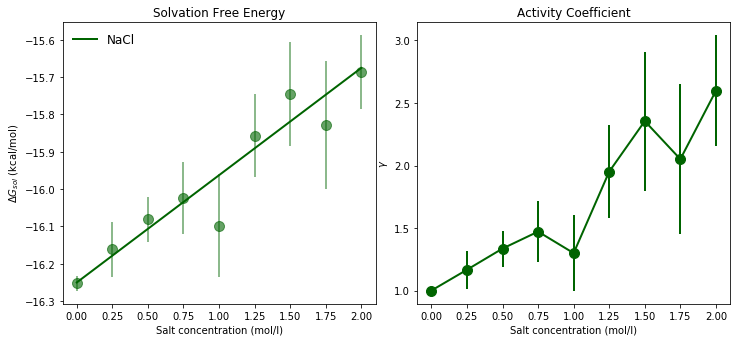

In [3]:
%cd -q $homedir
kcal_to_kT = 1.688 # Assuming 298.15 K

with open('Simulations/_results.yml') as f: # open structured result file (YAML)
    
    r = yaml.load(f, Loader=yaml.Loader)
    
    fig, (ax1, ax2) = plt.subplots(1,2, sharex=True)
    fig.set_size_inches(10,4.5)
    fig.tight_layout()
    
    for d in r['salts']: # loop over all salt types
        conc   = np.array(d['conc'])                       # molar conc.
        mu     = unumpy.uarray(d['muexcess'], d['error'])  # excess chem. pot. and error
        mu0    = mu[0]                                     # in pure water
        gamma  = unumpy.exp( (mu-mu0)*kcal_to_kT )         # activity coefficient
        fit    = np.polyfit(conc, unumpy.nominal_values(mu), 1, w=1/unumpy.std_devs(mu))
        fit_fn = np.poly1d(fit)
        print("Setschenow coefficient ("+d['label']+") =", fit[0])
        ax1.errorbar(conc, unumpy.nominal_values(mu), yerr=unumpy.std_devs(mu),
                     fmt='o', c=d['color'], alpha=0.6, ms=10)
        ax1.plot(conc, fit_fn(conc), label=d['label'], c=d['color'], lw=2, ms=10)
        ax2.errorbar(conc, unumpy.nominal_values(gamma), yerr=unumpy.std_devs(gamma),
                     label=d['label'], c=d['color'], lw=2, marker='o', ms=10)

    ax1.set_title('Solvation Free Energy')
    ax2.set_title('Activity Coefficient')
    ax1.set_xlabel('Salt concentration (mol/l)')
    ax1.set_ylabel('$\Delta G_{sol}$ (kcal/mol)')
    ax2.set_xlabel('Salt concentration (mol/l)')
    ax2.set_ylabel('$\gamma$')
    ax1.legend(loc=2, frameon=False, fontsize='large')
#plt.savefig('images/Free_energy.pdf', bbox_inches='tight')
plt.show()

In [7]:
%cd -q $homedir

with open('Simulations/_results.yml') as f: # open structured result file (YAML)
    r = yaml.load(f, Loader=yaml.Loader)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)
    width=0.3
    offset=0
    index = np.arange(4)
    
    for d in r['salts']: # loop over all salt types
        mu = unumpy.uarray(d['decomposition'][0]['mu'], d['decomposition'][0]['error'])
        ax.bar( index+offset, unumpy.nominal_values(mu),
                color=d['color'], label=d['label'], width=width,
                alpha=0.7, yerr=unumpy.std_devs(error), capsize=2)
        offset = offset + width
ax.set_xticks(index + width / 2)
ax.set_xticklabels(('Total', 'Water', 'Cations', 'Anions'))
ax.set_ylabel('$\Delta G_{sol}$ (kcal/mol)')
#ax.set_title('Free energy decomposition (2 M)')
ax.legend(loc=0, frameon=False, fontsize='large')
#plt.savefig('solvent-decomposition.pdf', bbox_inches='tight')
plt.show()

ParserError: while parsing a flow node
expected the node content, but found ','
  in "Simulations/_results.yml", line 7, column 66

## Decomposition by Caffeine Motifs

Todo...